### Census API: U.S. exports by partner


*Brian Dew, @bd_econ, December 14, 2019*

The Census Bureau allows API access to data on international trade. This example retrieves the June 2018 US export values by partner. Documentation for the Census international trade API is [here](https://www.census.gov/data/developers/data-sets/international-trade.html). The list of variables is [here](https://api.census.gov/data/timeseries/intltrade/exports/hs/variables.html)

#### Requirements:

Python (3.7 used), requests, pandas.

Also requires API key, free from Census, which I've stored locally in a file called config.py.

In [1]:
# import packages
import requests
import pandas as pd
from config import census_key as key

#### API Parameters/ Settings

In [2]:
# time series API: https://api.census.gov/data/timeseries.html
base = 'https://api.census.gov/data/timeseries/'
flow = 'intltrade/exports/hs'
param = 'CTY_CODE,CTY_NAME,ALL_VAL_MO'

# date needs manual update from release schedule:
# https://www.census.gov/foreign-trade/reference/release_schedule.html
time = '2020-02' 

url = f'{base}{flow}?get={param}&key={key}&time={time}'

#### Request data from API

In [3]:
# send request to census api and read response as json data
r = requests.get(url).json()

# print first five observations
r[:5]

[['CTY_CODE', 'CTY_NAME', 'ALL_VAL_MO', 'time'],
 ['-', 'TOTAL FOR ALL COUNTRIES', '132056617696', '2020-02'],
 ['0001', 'OPEC', '4020670574', '2020-02'],
 ['0003', 'EUROPEAN UNION', '22697237754', '2020-02'],
 ['0014', 'PACIFIC RIM COUNTRIES', '29941223815', '2020-02']]

#### Clean the data

The result is a list of observations, where each observation includes a country code, a country name, the value of exports, and the time period. I'm interested only in countries (not regional groupings) and the export value, so I select those two pieces of each observation's data, if the data cover a country (country code between 1000 and 8000).

In [4]:
# keep country name (pos 1) and export value in billions
d = [[i[1], int(i[2]) / 1000000000] for i in r 
     if i[0].isdigit() 
     and int(i[0]) in range(1000, 8000)] # country codes

d[:5]

[['GREENLAND', 3.0124e-05],
 ['CANADA', 23.147053321],
 ['ST PIERRE AND MIQUELON', 0.0],
 ['MEXICO', 19.397470423],
 ['GUATEMALA', 0.683485417]]

In [5]:
data = (pd.Series(dict(d)).sort_values())

data.tail()

JAPAN              6.087824
UNITED KINGDOM     6.486610
CHINA              6.815003
MEXICO            19.397470
CANADA            23.147053
dtype: float64

#### Plot the top 20 partners by export volume

I'm partial to very simple horizontal bar plots with no axis. Making these with matplotlib becomes intuitive after a bit of practice. Basically, I just add each element that I want to show: a title, country labels, blue bars in lengths according to the series values, series value labels, and a footer. 

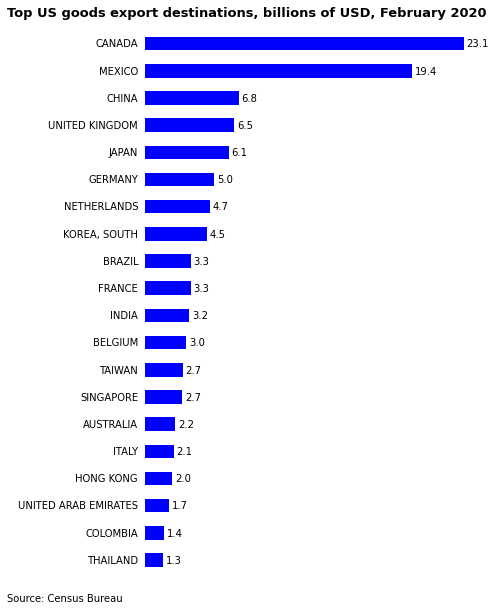

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot top 20 partners
s = data.tail(20)
s.plot(kind='barh', figsize=(6,10), color='blue')

# add value labels to ends of bars and country names to start of bars
for i, val in enumerate(s):
    plt.text(val+0.2, i-0.11, f'{val:.1f}')
    plt.text(-0.5, i-0.11, s.index[i], ha='right')
    
# add title and footer
plt.text(-10, 20, 'Top US goods export destinations, billions of USD, February 2020', 
          fontsize=13, weight='bold')
plt.text(-10, -1.5, 'Source: Census Bureau')

plt.axis('off')
plt.show()